In [0]:
%matplotlib inline
from google.colab import files
from functools import partial
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.special
mpl.rcParams['figure.dpi'] = 100
plt.style.use('seaborn-dark')
np.random.seed(94115)


# Law of large numbers

### Warm-up

This class is **not** about proving theorems! But we can toy with this famous theorem, which underlies what we are doing in the first lesson. It's a fun warm-up for translating statistical thinking into simulations and data!

These questions refer to this theorem and the code cell below.

**Law of large numbers**. Let $X_1, X_2, ...$ be a sequence of independent identically distributed random variables with finite mean $E(X_1) = \mu$ and finite variance $V(X_1) = \sigma^2$. Let  $S_n = \sum_{i=1}^n X_i$. Then, $\text{ as } n \rightarrow \infty$

$$
\tfrac{1}{n} S_n \rightarrow \mu  \text{ almost surely }.
$$

Loose translation: $\tfrac{1}{n} S_n \rightarrow \mu$ means that if we calculate the average of a large data set it should be very close to the theoretical mean of the underlying distribution. "Almost surely" means we can rely on this to always happen, so long as our data set is a random sample from a well-behaved data-generating process.

### Two properties of estimators

The goal of this law of large numbers analysis is to get some familiarity with notation and programing. We also want to justify our analysis of identification in terms of the underlying population parameters, rather than raw data. The next two properties show that averages calculated on data should be close to the population parameter. We can even think of them as the population paramters + "noise." By working directly with the population parameters we throw away the noise and allow ourselves to focus on what matters for identification.

**Consistency**: The law of large numbers is closely related to the idea of _consistency_. Consistency is a property of an estimator. If $\hat{\theta}_n$ is an estimator of the parameter $\theta$, then consistency means that $\hat{\theta}_n \rightarrow \theta$ as $n \rightarrow \infty$. This is a good property because it means that for large samples our estimate should be close to the true value. By the law of large numbers, we know that the sample mean is a consistency estimator of the expectation.
consistency
**Unbiasedness**: Unbiasedness is another desireable property of an estimator. If $\hat{\theta}$ is an estimator of the parameter $\theta$, then unbiasedness means that $E[\hat{\theta}] = \theta$. It is easy to prove that the sample mean is also an unbiased estimator of the expectation. 



(The theorem is adapted from Grimmett and Stirzaker. *Probability and Random Processes*. 2001.)

Text(0, 0.5, '$S_n$')

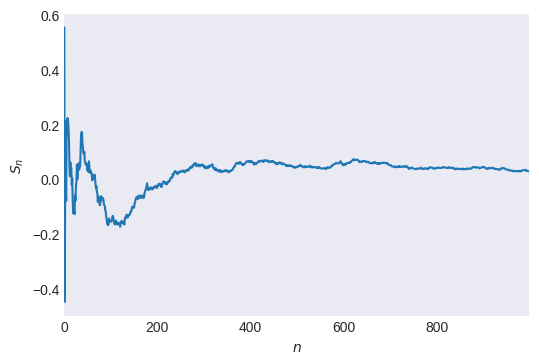

In [2]:
# Code for the warm-up above
X_n = np.random.normal(loc=0, scale=1, size=(10 ** 3, 1))
partial_sums = X_n.cumsum(axis=0)
n_index = np.arange(start=1, stop=len(partial_sums) + 1).reshape((-1, 1))
partial_means = np.divide(partial_sums, n_index)
ax = pd.DataFrame(partial_means).plot(legend=False)
ax.set_xlabel("$n$")
ax.set_ylabel("$S_n$")

In [0]:
# Let's package the simulation in a function.

def simulate_lln(distribution, sequence_length=10 ** 3):
  # Generate the sequence {X_i}
  X_n = distribution(size=(sequence_length, 1))
  # Calculate the partial sums S_n = sum of X_i from i=1 to i=n
  partial_sums = X_n.cumsum(axis=0)
  # Calculate the partial sums for all n
  n_index = np.arange(start=1, stop=len(partial_sums)+1).reshape((-1, 1))
  # Divide by {n} to get the partial averages
  partial_means = np.divide(partial_sums, n_index)

  means = pd.DataFrame(partial_means, index=n_index[:,0], columns=['mean_n'])
  return means

In [0]:
# Let's make two functions for graphing.
def plot_one(means_one_sequence, title=""):
  """Use to plot one sequence of partial means"""
  label = r"Partial mean, $\frac{1}{n}\sum_{i=0}^n{X_i}$"
  ax = means_one_sequence.plot(linewidth=2, alpha=0.8, label=label, legend=True, color='#fa8174', figsize=(6, 4))
  ax.set_xlabel("Sample size, $n$", fontsize=18)
  ax.set_ylabel(r"Mean", fontsize=18)
  ax.tick_params(labelsize=18)
  ax.set_title("Law of large numbers\n{}".format(title), fontsize=18)
  leg = ax.legend(fontsize=18)

  return ax

def plot_many(means_data, title=""):
  """Use to plot many sequences of partial means"""
  ax = means_data.plot(linewidth=1, alpha=0.3, figsize=(6, 4), legend=False)
  ax.set_xlabel("Sample size, $n$", fontsize=18)
  ax.set_ylabel(r"Mean", fontsize=18)
  ax.tick_params(labelsize=18)
  ax.set_title("Law of large numbers\n{}".format(title), fontsize=18)

  return ax



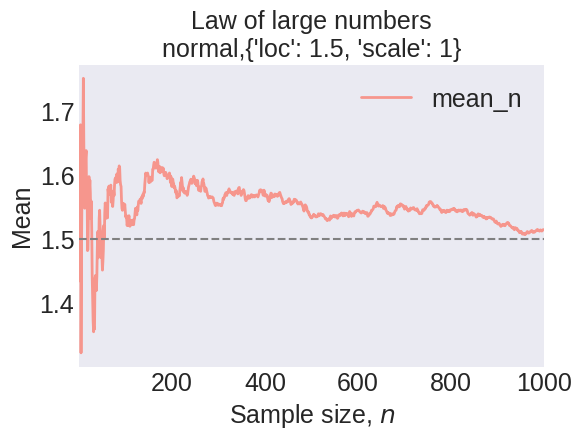

In [5]:
expectation_X = 1.5
standard_dev_X = 1
# We can use `partial` to fill in some of the arguments and leave some for later.
distribution = partial(np.random.normal, loc=expectation_X, scale=standard_dev_X)
means = simulate_lln(distribution)

title = ",".join([distribution.func.__name__, str(distribution.keywords)])
ax = plot_one(means.loc[0:10000], title)
ax.axhline(y=expectation_X, linestyle='--', color='grey')


# Selection bias

1. Read the code comments to understand this particular case.
2. If you need more background reading, review the readings from lecture 1.
3. Do not use the Wikipedia article for "selection bias." It is not appropriate for causal inference.

In [6]:
# Total number of persons in the study
# Set large enough to make sampling variation negligible.
N = 10 ** 6

# Each person has an individual level of "charitability".
# We'll model this charitability as being normally distributed.
charitability = np.random.normal(loc=-1, scale=0.5, size=N)


# Draw the potential outcomes from a lognormal distribution.
# The outcome Y0 has a mean based on the charitability level:
# A higher charitability tends to increase the donation amount.
# Y1 is set to be identical to Y0. This means the ad has no effect!
# The technical term for the condition Y1=Y0 for all units is
# the "sharp null hypothesis."
Y0 = np.random.lognormal(mean=(charitability + 0.5), sigma=0.1, size=N)
Y1 = Y0.copy()


# The probability of searching for Doctors Without Borders is
# a function of the charitability level. People who are more 
# charitable are more likely to search for DWB.
# We assume that anyone who searches for DWB will see the DWB ad.
prob_search_dwb = scipy.special.expit(charitability)

D = np.random.binomial(n=1, p=prob_search_dwb)
print(np.dot(prob_search_dwb,D)/np.sum(D))
print(np.sum(D)/N)
# Calculate the *actual* outcome.
Y = Y1 * D + Y0 * (1 - D)

# Put the data together for analysis.
df = pd.DataFrame({
    'D': D,
    'Y0': Y0, 
    'Y1': Y1, 
    'Y': Y,
    'delta': Y1 - Y0,
    'C': charitability,
})

print(df[(df.C > 0.5) & (df.C < 0.6)])

0.31327241084783475
0.279275
        D        Y0        Y1         Y  delta         C
811     1  2.848258  2.848258  2.848258    0.0  0.567635
1697    1  2.896422  2.896422  2.896422    0.0  0.523142
2700    0  2.509519  2.509519  2.509519    0.0  0.520026
11801   1  3.100205  3.100205  3.100205    0.0  0.534966
12659   1  2.490333  2.490333  2.490333    0.0  0.513902
...    ..       ...       ...       ...    ...       ...
994277  1  2.595684  2.595684  2.595684    0.0  0.534225
994788  1  2.935649  2.935649  2.935649    0.0  0.566913
994965  1  2.796922  2.796922  2.796922    0.0  0.564656
995896  0  2.918690  2.918690  2.918690    0.0  0.579983
999804  1  2.960929  2.960929  2.960929    0.0  0.505772

[672 rows x 6 columns]


In [7]:
''' MODIFIED----------------------------------------------------------'''
#Total number of persons in the study
# Set large enough to make sampling variation negligible.
N = 10 ** 6

# Each person has an individual level of "charitability".
# We'll model this charitability as being normally distributed.
charitability = np.random.normal(loc=-1, scale=0.5, size=N)


# Draw the potential outcomes from a lognormal distribution.
# The outcome Y0 has a mean based on the charitability level:
# A higher charitability tends to increase the donation amount.
# Y1 is set to be identical to Y0. This means the ad has no effect!
# The technical term for the condition Y1=Y0 for all units is
# the "sharp null hypothesis."
Y0 = np.random.lognormal(mean=(charitability + 0.5), sigma=0.1, size=N)
Y1 = Y0.copy()


# The probability of searching for Doctors Without Borders is
# a function of the charitability level. People who are more 
# charitable are more likely to search for DWB.
# We assume that anyone who searches for DWB will see the DWB ad.
prob_search_dwb = scipy.special.expit(charitability)

D_exp = np.random.binomial(n=1,p = 0.5,size = N)

print(np.sum(D_exp)/N)

# Calculate the *actual* outcome.
Y = Y1 * D_exp + Y0 * (1 - D_exp)

# Put the data together for analysis.
df_new = pd.DataFrame({
    'D_exp': D_exp,
    'Y0': Y0, 
    'Y1': Y1, 
    'Y': Y,
    'delta': Y1 - Y0,
    'C': charitability,
})
print(df_new)

0.500429
        D_exp        Y0        Y1         Y  delta         C
0           1  0.498527  0.498527  0.498527    0.0 -1.192435
1           1  0.503280  0.503280  0.503280    0.0 -1.187660
2           0  0.209965  0.209965  0.209965    0.0 -1.964243
3           0  1.287278  1.287278  1.287278    0.0 -0.255493
4           0  0.595973  0.595973  0.595973    0.0 -0.964903
...       ...       ...       ...       ...    ...       ...
999995      0  0.541018  0.541018  0.541018    0.0 -1.014610
999996      1  0.956737  0.956737  0.956737    0.0 -0.569991
999997      1  0.793770  0.793770  0.793770    0.0 -0.738728
999998      0  1.038907  1.038907  1.038907    0.0 -0.396946
999999      0  1.251797  1.251797  1.251797    0.0 -0.435471

[1000000 rows x 6 columns]


In [8]:
''' MODIFIED_with different Y1----------------------------------------------------------'''
#Total number of persons in the study
# Set large enough to make sampling variation negligible.
N = 10 ** 6

# Each person has an individual level of "charitability".
# We'll model this charitability as being normally distributed.
charitability = np.random.normal(loc=-1, scale=0.5, size=N)


# Draw the potential outcomes from a lognormal distribution.
# The outcome Y0 has a mean based on the charitability level:
# A higher charitability tends to increase the donation amount.
# Y1 is set to be identical to Y0. This means the ad has no effect!
# The technical term for the condition Y1=Y0 for all units is
# the "sharp null hypothesis."
Y0 = np.random.lognormal(mean=(charitability + 0.5), sigma=0.1, size=N)
Y1_new = Y0 + 0.3


# The probability of searching for Doctors Without Borders is
# a function of the charitability level. People who are more 
# charitable are more likely to search for DWB.
# We assume that anyone who searches for DWB will see the DWB ad.
prob_search_dwb = scipy.special.expit(charitability)

D_exp = np.random.binomial(n=1,p = 0.5,size = N)

print(np.sum(D_exp)/N)

# Calculate the *actual* outcome.
Y = Y1_new * D_exp + Y0 * (1 - D_exp)

# Put the data together for analysis.
df_new_1 = pd.DataFrame({
    'D_exp': D_exp,
    'Y0': Y0, 
    'Y1': Y1_new, 
    'Y': Y,
    'delta': Y1_new - Y0,
    'C': charitability,
})
print(df_new_1)

0.499405
        D_exp        Y0        Y1         Y  delta         C
0           1  0.262054  0.562054  0.562054    0.3 -1.975462
1           0  0.398301  0.698301  0.398301    0.3 -1.325765
2           0  0.874945  1.174945  0.874945    0.3 -0.492637
3           0  0.485827  0.785827  0.485827    0.3 -1.230159
4           0  0.834871  1.134871  0.834871    0.3 -0.750024
...       ...       ...       ...       ...    ...       ...
999995      0  0.723415  1.023415  0.723415    0.3 -0.739665
999996      0  0.669979  0.969979  0.669979    0.3 -0.864053
999997      1  0.548132  0.848132  0.848132    0.3 -0.932607
999998      1  0.554676  0.854676  0.854676    0.3 -0.994116
999999      1  1.520367  1.820367  1.820367    0.3 -0.152952

[1000000 rows x 6 columns]


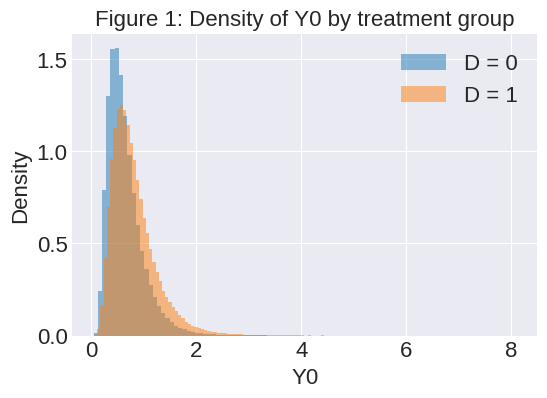

In [9]:
column_to_plot = 'Y0'
ax = df.query('D==0')[column_to_plot].hist(bins=100, alpha=0.5, density=True, label='D = 0')
ax = df.query('D==1')[column_to_plot].hist(bins=100, alpha=0.5, density=True, ax=ax, label='D = 1')
ax.legend(fontsize=16)
ax.set_xlabel(column_to_plot, fontsize=16)
ax.set_ylabel('Density', fontsize=16)
ax.set_title("Figure 1: Density of {} by treatment group".format(column_to_plot), fontsize=16)
ax.tick_params(labelsize=16)

 

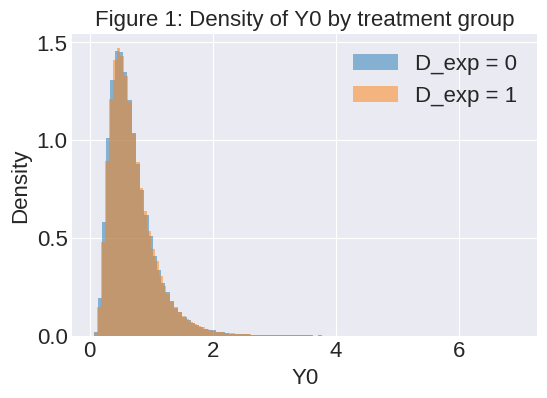

In [10]:
'''MODIFIED------------------------------------------------------------------------------------------------------'''
column_to_plot = 'Y0'
ax = df_new.query('D_exp==0')[column_to_plot].hist(bins=100, alpha=0.5, density=True, label='D_exp = 0')
ax = df_new.query('D_exp==1')[column_to_plot].hist(bins=100, alpha=0.5, density=True, ax=ax, label='D_exp = 1')
ax.legend(fontsize=16)
ax.set_xlabel(column_to_plot, fontsize=16)
ax.set_ylabel('Density', fontsize=16)
ax.set_title("Figure 1: Density of {} by treatment group".format(column_to_plot), fontsize=16)
ax.tick_params(labelsize=16)

 

In [11]:
# Tabulate all the averages sliced by treatment vs. control
df.groupby('D').mean()

,Y0,Y1,Y,delta,C
D,,,,,
0,0.642120,0.642120,0.642120,0.0,-1.066920
1,0.814983,0.814983,0.814983,0.0,-0.827018


In [12]:
'''MODIFIED-------------------------------------------------------------------------------------------------'''
# Tabulate all the averages sliced by treatment vs. control
df_new.groupby('D_exp').mean()

,Y0,Y1,Y,delta,C
D_exp,,,,,
0,0.691239,0.691239,0.691239,0.0,-0.999434
1,0.690535,0.690535,0.690535,0.0,-1.000657


In [13]:
'''MODIFIED-------------------------------------------------------------------------------------------------'''
# Tabulate all the averages sliced by treatment vs. control
df_new_1.groupby('D_exp').mean()


,Y0,Y1,Y,delta,C
D_exp,,,,,
0,0.690656,0.990656,0.690656,0.3,-1.000444
1,0.690953,0.990953,0.990953,0.3,-0.999689


In [14]:
# Here's another way to calculate the averages from the table.

# Calculate E[Y]
df['Y'].mean()

# Calculate E[Y0 | D=0]​ Problem Set 1

print("E[Y0|D=0] = {}".format(df.query("D == 0")['Y0'].mean()))

print("E[Y1|D=1] = {}".format(df.query("D == 1")['Y1'].mean()))

print("E[Y1|D=1] - E[Y0|D=0] = {}".format(df.query("D == 1")['Y1'].mean() - df.query("D == 0")['Y0'].mean()))


E[Y0|D=0] = 0.6421200313934637
E[Y1|D=1] = 0.8149830378531068
E[Y1|D=1] - E[Y0|D=0] = 0.17286300645964303


In [15]:
'''MODIFIED-----------------------------------------------------------------------------------------------------------'''
# Here's another way to calculate the averages from the table.

# Calculate E[Y]
df_new_1['Y'].mean()

# Calculate E[Y0 | D=0]​ Problem Set 1

print("E[Y0|D=0] = {}".format(df_new_1.query("D_exp == 0")['Y0'].mean()))

print("E[Y1|D=1] = {}".format(df_new_1.query("D_exp == 1")['Y1'].mean()))

print("E[Y1|D=1] - E[Y0|D=0] = {}".format(df_new_1.query("D_exp == 1")['Y1'].mean() - df_new_1.query("D_exp == 0")['Y0'].mean()))


E[Y0|D=0] = 0.6906558077773224
E[Y1|D=1] = 0.9909531686266129
E[Y1|D=1] - E[Y0|D=0] = 0.3002973608492905


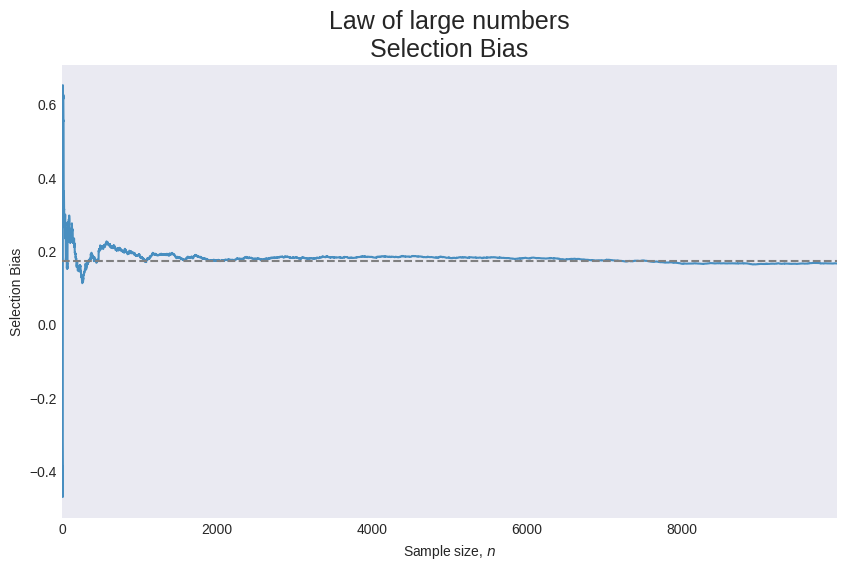

In [33]:
# Code for the warm-up above
def selection_bias(df,n):
  import math
  df_agg = df.loc[:n].groupby('D').mean()

  k = df_agg['Y0']

  try:
    a = k[1]
  except:
    a = 0
  try:
    b = k[0]
  except:
    b = 0
  
  SB = a - b
  return SB
SB = selection_bias(df,2)

SB_df = pd.DataFrame(columns = ['Selection_Bias'])

for j in range(1,10001):
  SB_df.loc[j-1] = selection_bias(df,j)

def plot_many(means_data, title=""):
  """Use to plot many sequences of partial means"""
  ax = means_data.plot(linewidth=1.5, alpha=0.8, figsize=(10, 6), legend=False)
  ax.set_xlabel("Sample size, $n$", fontsize=10)
  ax.set_ylabel(r"Selection Bias", fontsize=10)
  ax.tick_params(labelsize=10)
  ax.set_title("Law of large numbers\n{}".format(title), fontsize=18)

  return ax
NATE = df.query("D == 1")['Y1'].mean() - df.query("D == 0")['Y0'].mean()
plot_many(SB_df,'Selection Bias')
plt.gca()
plt.axhline(y=NATE, linestyle='--', color='grey')
plt.show()

